<a href="https://colab.research.google.com/github/seongwoojang1123/Exploring-Key-Determinants-of-Halitosis-Through-a-Data-Analysis/blob/main/3_Feature_Importance_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import random

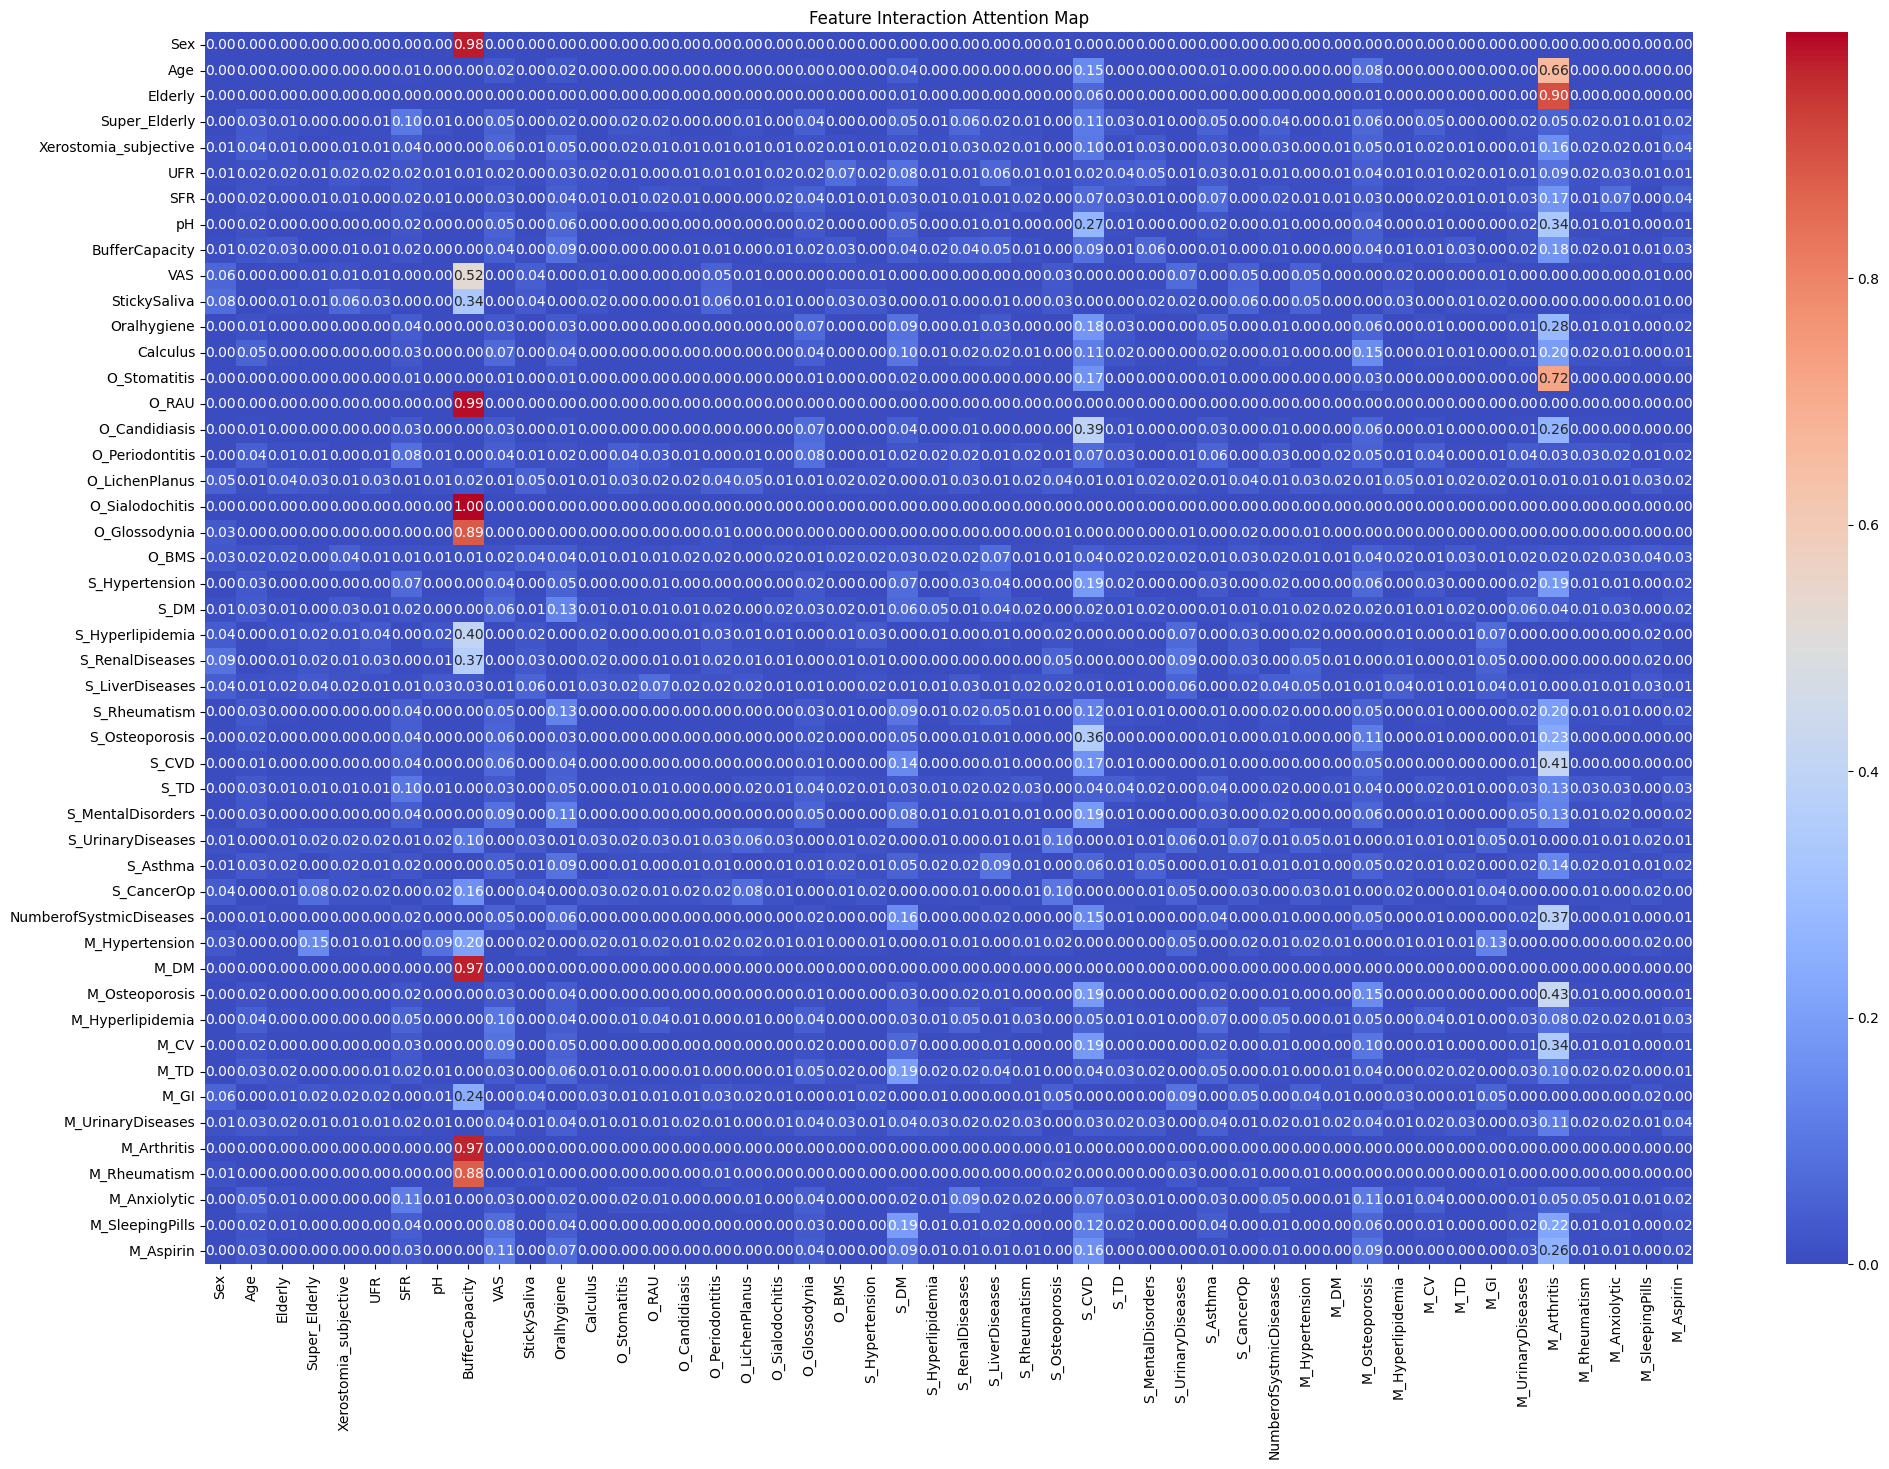

In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Data load
excel_path = "/content/drive/MyDrive/Halitosis/241121_Halitosis_data preprocessing.xlsx"

features = ['Sex', 'Age', 'Elderly', 'Super_Elderly', 'Xerostomia_subjective', 'UFR', 'SFR', 'pH', 'BufferCapacity',
          'VAS', 'StickySaliva', 'Oralhygiene', 'Calculus', 'O_Stomatitis', 'O_RAU', 'O_Candidiasis', 'O_Periodontitis',
          'O_LichenPlanus', 'O_Sialodochitis', 'O_Glossodynia', 'O_BMS', 'S_Hypertension', 'S_DM', 'S_Hyperlipidemia',
          'S_RenalDiseases', 'S_LiverDiseases', 'S_Rheumatism', 'S_Osteoporosis', 'S_CVD', 'S_TD', 'S_MentalDisorders',
          'S_UrinaryDiseases', 'S_Asthma', 'S_CancerOp', 'NumberofSystmicDiseases', 'M_Hypertension', 'M_DM',
          'M_Osteoporosis', 'M_Hyperlipidemia', 'M_CV', 'M_TD', 'M_GI', 'M_UrinaryDiseases', 'M_Arthritis',
          'M_Rheumatism', 'M_Anxiolytic', 'M_SleepingPills', 'M_Aspirin']

target_column = "Halitosis_subjective"

data = pd.read_excel(excel_path)

X = data[features]
y = data[target_column]

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)

if len(y.shape) == 1:
    y_tensor = torch.tensor(y.values, dtype=torch.long)
else:
    y_tensor = torch.tensor(y.values, dtype=torch.long).squeeze()

# Self-Attention
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Query, Key, Value calculate
        Q = self.query(x)  # (batch_size, input_dim)
        K = self.key(x)    # (batch_size, input_dim)
        V = self.value(x)  # (batch_size, input_dim)

        # Attention Score calculate
        attention_scores = torch.matmul(Q.T, K) / np.sqrt(Q.shape[1])  # (input_dim, input_dim)
        attention_weights = self.softmax(attention_scores)  # (input_dim, input_dim)

        attended_output = torch.matmul(attention_weights, V.T).T  # (batch_size, input_dim)
        return attended_output, attention_weights

# Self-Attention Model initialization
input_dim = X_tensor.shape[1]
attention_model = SelfAttention(input_dim)

attention_model.eval()

with torch.no_grad():
    _, attention_weights = attention_model(X_tensor)

attention_weights_np = attention_weights.numpy()  # (input_dim, input_dim)

assert attention_weights_np.shape[0] == len(features), f"Feature 수({len(features)})와 Attention Map 차원({attention_weights_np.shape[0]})이 일치하지 않습니다."

plt.figure(figsize=(24, 16))
sns.heatmap(
    attention_weights_np,
    annot=True,
    fmt=".2f",
    xticklabels=features,
    yticklabels=features,
    cmap="coolwarm"
)
plt.title("Feature Interaction Attention Map")
plt.show()

Feature Importance Ranking:
                    Feature  Importance
18          O_Sialodochitis    0.020383
14                    O_RAU    0.019908
0                       Sex    0.019529
36                     M_DM    0.019306
43              M_Arthritis    0.019142
2                   Elderly    0.016675
19            O_Glossodynia    0.015955
44             M_Rheumatism    0.015769
13             O_Stomatitis    0.010976
1                       Age    0.009225
9                       VAS    0.005714
37           M_Osteoporosis    0.004668
15            O_Candidiasis    0.004520
28                    S_CVD    0.004392
27           S_Osteoporosis    0.003888
7                        pH    0.003757
34  NumberofSystmicDiseases    0.003678
23         S_Hyperlipidemia    0.003365
39                     M_CV    0.003318
24          S_RenalDiseases    0.003013
10             StickySaliva    0.002486
11              Oralhygiene    0.002408
47                M_Aspirin    0.002244
46          

<ipython-input-5-6f46ce2c6d49>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


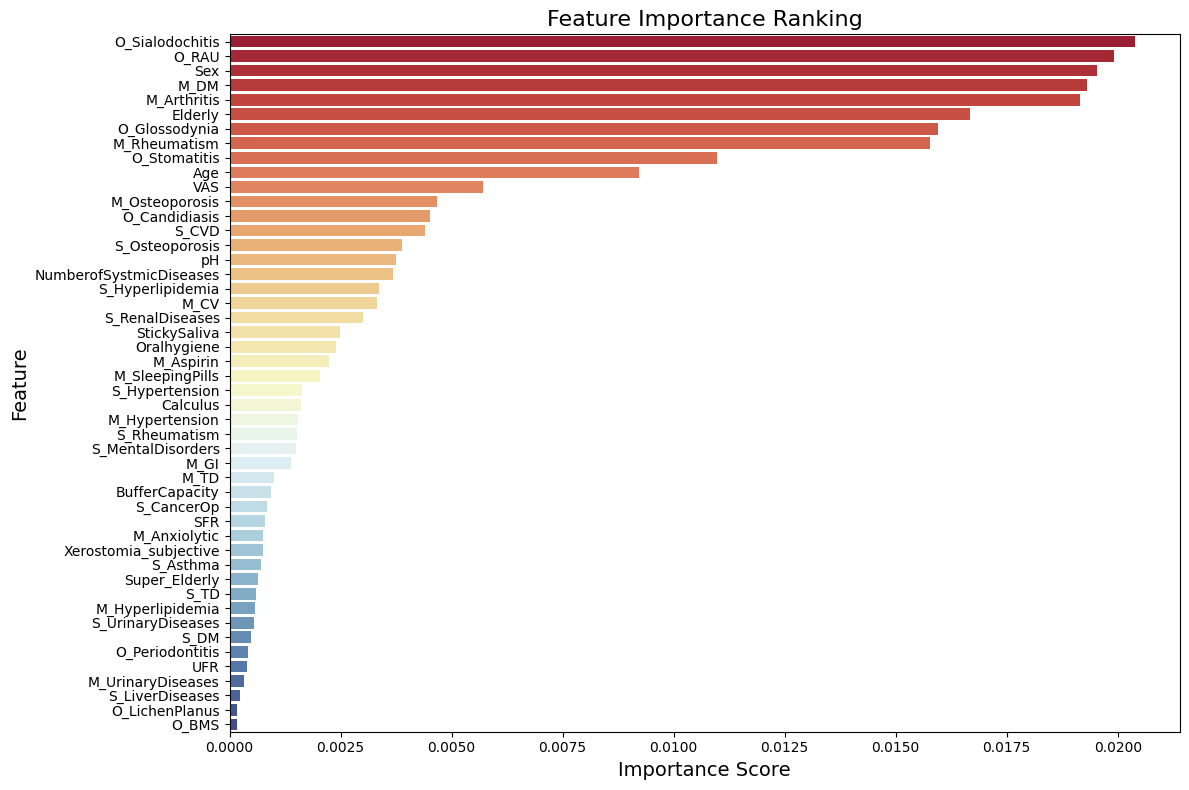

In [5]:
# Feature Importance
feature_importance = np.var(attention_weights_np, axis=1)  # 분산 계산

# Feature Ranking
feature_ranking = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print("Feature Importance Ranking:")
print(feature_ranking)

plt.figure(figsize=(12, 8))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_ranking,
    palette="RdYlBu"
)
plt.title("Feature Importance Ranking", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Feature-Target Correlation:
                    Feature  Correlation
13             O_Stomatitis     0.075470
42        M_UrinaryDiseases     0.058485
4     Xerostomia_subjective     0.050147
37           M_Osteoporosis     0.044861
24          S_RenalDiseases     0.033107
39                     M_CV     0.030263
33               S_CancerOp     0.027081
47                M_Aspirin     0.024887
27           S_Osteoporosis     0.015036
28                    S_CVD     0.009034
7                        pH     0.006669
25          S_LiverDiseases     0.004763
43              M_Arthritis     0.001398
16          O_Periodontitis    -0.004585
46          M_SleepingPills    -0.011625
10             StickySaliva    -0.012234
11              Oralhygiene    -0.012552
35           M_Hypertension    -0.012847
9                       VAS    -0.020110
30        S_MentalDisorders    -0.020825
20                    O_BMS    -0.027124
0                       Sex    -0.027799
44             M_Rheumatism  

<ipython-input-6-95850948b215>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


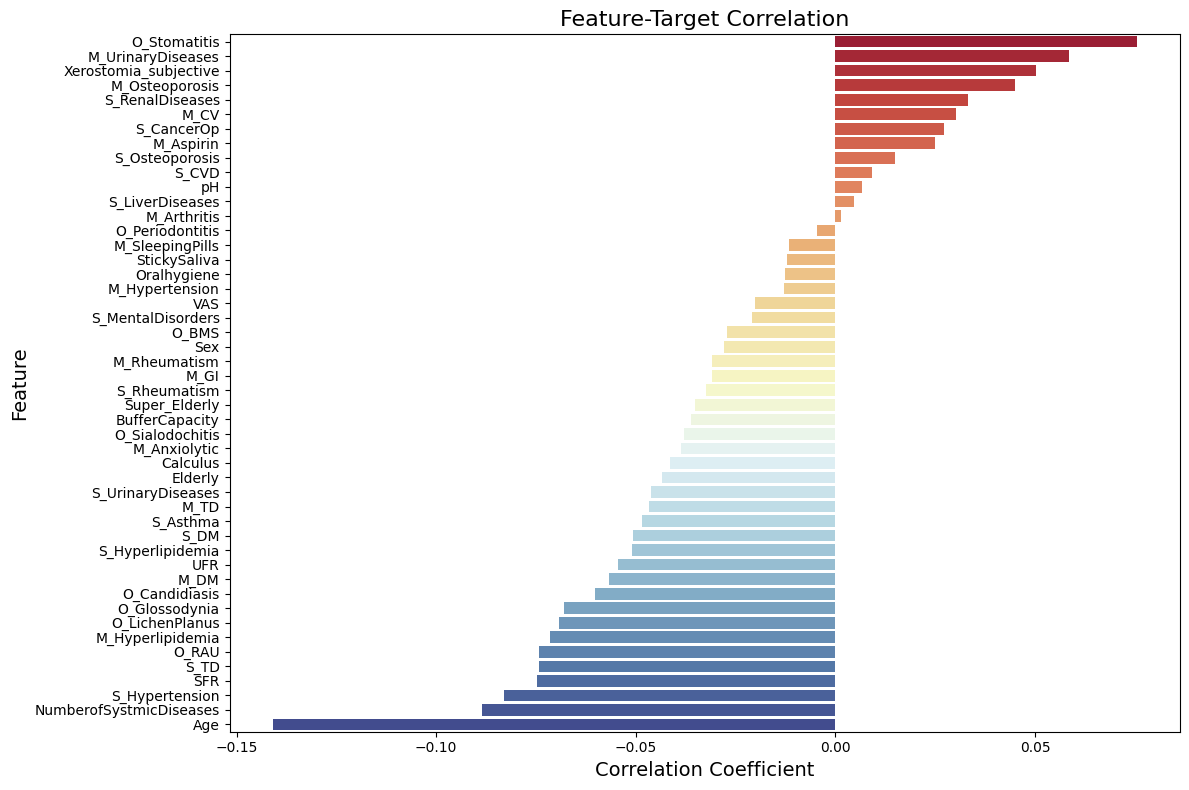

In [6]:
# correlation analysis
correlations = []
for feature in features:
    corr = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(corr)

correlation_df = pd.DataFrame({
    "Feature": features,
    "Correlation": correlations
}).sort_values(by="Correlation", ascending=False)

print("Feature-Target Correlation:")
print(correlation_df)

plt.figure(figsize=(12, 8))
sns.barplot(
    x="Correlation",
    y="Feature",
    data=correlation_df,
    palette="RdYlBu"
)
plt.title("Feature-Target Correlation", fontsize=16)
plt.xlabel("Correlation Coefficient", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Top 10 Feature Pairs with High Attention Scores:
          Feature 1       Feature 2  Attention Score
0   O_Sialodochitis  BufferCapacity         0.999617
1             O_RAU  BufferCapacity         0.988127
2               Sex  BufferCapacity         0.978855
3              M_DM  BufferCapacity         0.973382
4       M_Arthritis  BufferCapacity         0.969294
5           Elderly     M_Arthritis         0.903776
6     O_Glossodynia  BufferCapacity         0.885956
7      M_Rheumatism  BufferCapacity         0.880936
8      O_Stomatitis     M_Arthritis         0.718815
9               Age     M_Arthritis         0.658176
10              VAS  BufferCapacity         0.524505


<ipython-input-7-b7966fde03d9>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


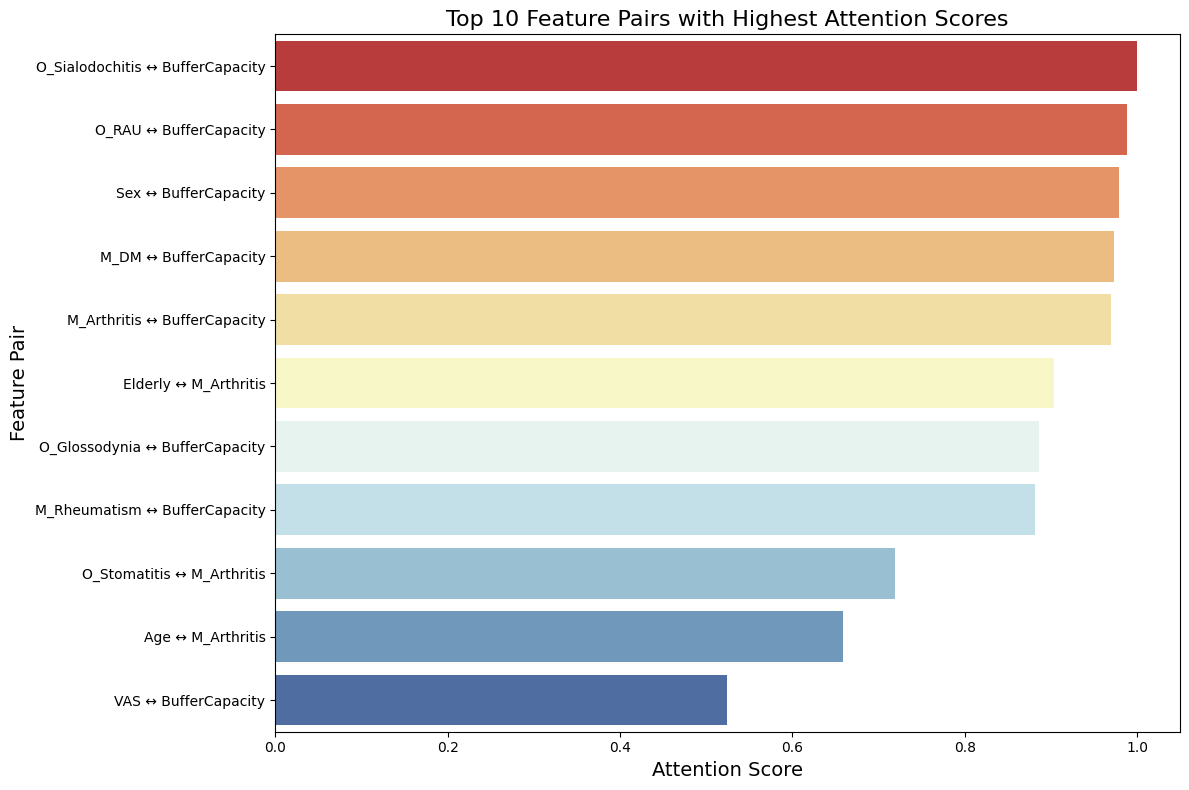

In [7]:
# Top 10 Feature Pairs with Highest Attention Scores

num_top_pairs = 11

attention_scores_flat = attention_weights_np.flatten()
sorted_indices = np.argsort(-attention_scores_flat)

top_scores = attention_scores_flat[sorted_indices[:num_top_pairs]]
top_indices = [np.unravel_index(idx, attention_weights_np.shape) for idx in sorted_indices[:num_top_pairs]]

top_feature_pairs = [
    {
        "Feature 1": features[idx[0]],
        "Feature 2": features[idx[1]],
        "Attention Score": score
    }
    for idx, score in zip(top_indices, top_scores)
]

top_feature_pairs_df = pd.DataFrame(top_feature_pairs)

print("Top 10 Feature Pairs with High Attention Scores:")
print(top_feature_pairs_df)

plt.figure(figsize=(12, 8))
sns.barplot(
    x="Attention Score",
    y=["{} ↔ {}".format(row["Feature 1"], row["Feature 2"]) for _, row in top_feature_pairs_df.iterrows()],
    data=top_feature_pairs_df,
    palette="RdYlBu"
)
plt.title("Top 10 Feature Pairs with Highest Attention Scores", fontsize=16)
plt.xlabel("Attention Score", fontsize=14)
plt.ylabel("Feature Pair", fontsize=14)
plt.tight_layout()
plt.show()
